<a href="https://colab.research.google.com/github/patrick-mead/patrick-mead.github.io/blob/main/volatility-drag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import itertools

# --- Configuration ---
N = 12
W0 = 1.0
u = 1.5
d = 0.6

In [45]:
# --- 1. Generate All Outcomes (Same as before) ---
all_outcomes = np.array(list(itertools.product([d, u], repeat=N)))
paths = np.hstack([np.ones((len(all_outcomes), 1)), all_outcomes])
wealth_paths = W0 * np.cumprod(paths, axis=1)
final_wealths = wealth_paths[:, -1]

# --- THE FIX: Round values to ignore microscopic float errors ---
# 8 decimals is plenty for this problem size
final_wealths_rounded = np.round(final_wealths, 8)

In [46]:
# --- 2. Create the Frequency Table ---
# distinct_wealths will naturally be sorted from lowest to highest
distinct_wealths, counts = np.unique(final_wealths_rounded, return_counts=True)

# Calculate the number of heads for each wealth value
# We can reverse engineer k (heads) from Wealth: W = W0 * u^k * d^(N-k)
# But it's easier to just count from 0 to N since distinct_wealths is sorted
heads_count = np.arange(len(distinct_wealths))

# Calculate probabilities
probabilities = counts / len(final_wealths_rounded)

# Create a clean DataFrame
df = pd.DataFrame({
    'Heads (k)': heads_count,
    'Wealth ($)': distinct_wealths,
    'Frequency (Paths)': counts,
    'Probability (%)': probabilities * 100
})

# Format the Wealth column to look like currency
pd.options.display.float_format = '{:,.4f}'.format

# --- 3. Display ---
print(f"Total Paths: {len(final_wealths_rounded)}")
print("-" * 60)
print(df.to_string(index=False))

Total Paths: 4096
------------------------------------------------------------
 Heads (k)  Wealth ($)  Frequency (Paths)  Probability (%)
         0      0.0022                  1           0.0244
         1      0.0054                 12           0.2930
         2      0.0136                 66           1.6113
         3      0.0340                220           5.3711
         4      0.0850                495          12.0850
         5      0.2126                792          19.3359
         6      0.5314                924          22.5586
         7      1.3286                792          19.3359
         8      3.3215                495          12.0850
         9      8.3038                220           5.3711
        10     20.7594                 66           1.6113
        11     51.8985                 12           0.2930
        12    129.7463                  1           0.0244


Simulation: 100000 paths over 52 steps
Parameters: Mean=1.0%/step, Vol=3.0%/step
------------------------------------------------------------
Ensemble Average (Mean):  $168.14 (Theoretical: $167.77)
Time Average (Median):    $164.26
Wealth Gap:               1.02x
------------------------------------------------------------
     Wealth Range  Frequency  Probability (%)
  $62.84 - $71.67          3           0.0030
  $71.67 - $81.75         47           0.0470
  $81.75 - $93.25        356           0.3560
 $93.25 - $106.36       1832           1.8320
$106.36 - $121.32       5741           5.7410
$121.32 - $138.38      13359          13.3590
$138.38 - $157.83      21214          21.2140
$157.83 - $180.03      23917          23.9170
$180.03 - $205.34      18574          18.5740
$205.34 - $234.22       9991           9.9910
$234.22 - $267.16       3735           3.7350
$267.16 - $304.72       1017           1.0170
$304.72 - $347.57        183           0.1830
$347.57 - $396.45         25  

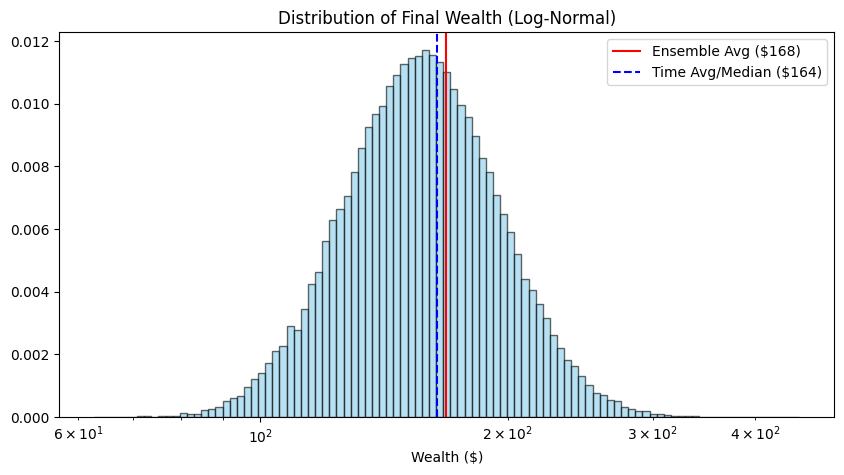

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
np.random.seed(42)
N_STEPS = 52       # e.g., 1 year of weekly data
N_SIMS = 100000    # Number of Monte Carlo simulations
W0 = 100.0         # Initial Wealth

# Asset Parameters (Weekly)
mu = 0.01          # Expected Arithmetic Return (+1% per week)
sigma = 0.03       # Volatility (5% per week)

# --- 1. Generate Returns ---
# We model Log-Returns as Normal: r_log ~ N(mu - 0.5*sigma^2, sigma)
# This ensures the Arithmetic Mean matches 'mu' exactly.
drift = mu - 0.5 * (sigma ** 2)
log_returns = np.random.normal(loc=drift, scale=sigma, size=(N_SIMS, N_STEPS))

# --- 2. Calculate Wealth ---
# Cumulative sum of log returns -> Exponentiate to get Price/Wealth
cumulative_log_returns = np.cumsum(log_returns, axis=1)
wealth_paths = W0 * np.exp(cumulative_log_returns)
final_wealth = wealth_paths[:, -1]

# --- 3. Calculate Averages ---
# Ensemble Average (Arithmetic Mean of all simulations)
ensemble_avg = np.mean(final_wealth)

# Time Average (Geometric Median / Typical Path)
# For Log-Normal, Median = exp(Mean of Logs)
time_avg = np.median(final_wealth) # or np.exp(np.mean(np.log(final_wealth)))

# --- 4. Create Frequency Table (Binning) ---
# Since outcomes are continuous, we must group them into ranges
# We create 15 bins based on log-spacing to handle the skew
min_w, max_w = final_wealth.min(), final_wealth.max()
bins = np.geomspace(min_w, max_w, 16) # 15 bins

# Use pandas to cut data into bins
# format_label converts interval (10, 20] to string "$10 - $20"
def format_interval(i):
    return f"${i.left:,.2f} - ${i.right:,.2f}"

df = pd.DataFrame({'Wealth': final_wealth})
df['Range'] = pd.cut(df['Wealth'], bins=bins)
summary = df['Range'].value_counts().sort_index().reset_index()
summary.columns = ['Wealth Range', 'Frequency']
summary['Probability (%)'] = (summary['Frequency'] / N_SIMS) * 100
summary['Wealth Range'] = summary['Wealth Range'].apply(format_interval)

# Add a "Representative Value" for the table (Geometric midpoint of bin)
summary['Approx Value'] = np.sqrt(bins[:-1] * bins[1:])

# --- 5. Display ---
print(f"Simulation: {N_SIMS} paths over {N_STEPS} steps")
print(f"Parameters: Mean={mu:.1%}/step, Vol={sigma:.1%}/step")
print("-" * 60)
print(f"Ensemble Average (Mean):  ${ensemble_avg:,.2f} (Theoretical: ${W0*(1+mu)**N_STEPS:,.2f})")
print(f"Time Average (Median):    ${time_avg:,.2f}")
print(f"Wealth Gap:               {ensemble_avg/time_avg:.2f}x")
print("-" * 60)
print(summary[['Wealth Range', 'Frequency', 'Probability (%)']].to_string(index=False))

# Optional: Quick Histogram
plt.figure(figsize=(10, 5))
plt.hist(final_wealth, bins=np.geomspace(min_w, max_w, 100), density=True, alpha=0.6, color='skyblue', edgecolor='black')
plt.axvline(ensemble_avg, color='red', label=f'Ensemble Avg (${ensemble_avg:,.0f})')
plt.axvline(time_avg, color='blue', linestyle='--', label=f'Time Avg/Median (${time_avg:,.0f})')
plt.xscale('log')
plt.title('Distribution of Final Wealth (Log-Normal)')
plt.xlabel('Wealth ($)')
plt.legend()
plt.show()